In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import time

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain
from exp_hp import get_hp

2024-08-14 15:08:02.119044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


2024-08-14 15:08:08.771826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load standardized CESM2-LE

5
Training Members: ['0201', '0211', '0221', '0231', '0241', '0251']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving
0
240/240 [==============================] - 34s 142ms/step
1
240/240 [==============================] - 34s 142ms/step
2
240/240 [==============================] - 33s 139ms/step
3
240/240 [==============================] - 35s 144ms/step
4
240/240 [==============================] - 34s 143ms/step
5
240/240 [==============================] - 34s 140ms/step
6
240/240 [==============================] - 35s 144ms/step
7
240/240 [==============================] - 34s 142ms/step
8
240/240 [==============================] - 34s 142ms/step
9
240/240 [==============================] - 34s 142ms/step


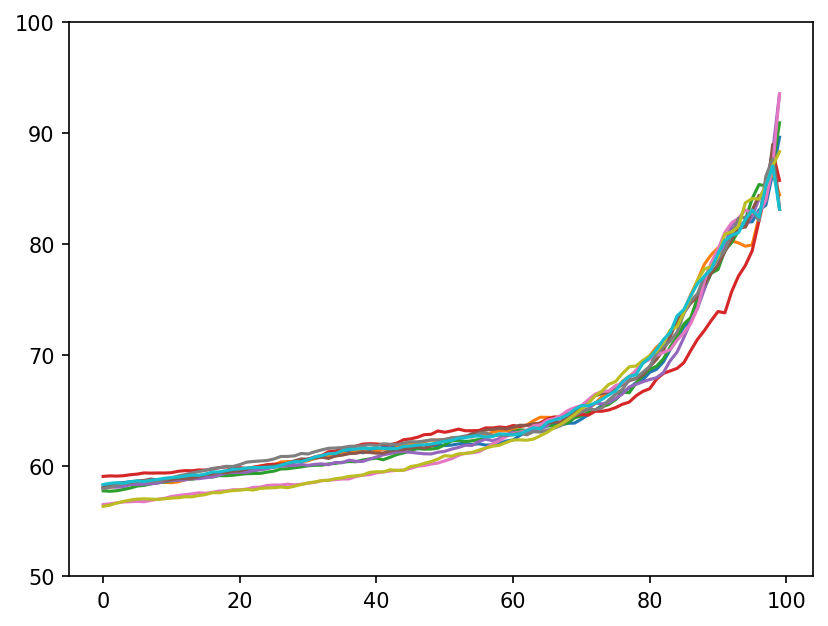

6
Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving
0
241/241 [==============================] - 34s 143ms/step
1
241/241 [==============================] - 34s 140ms/step
2
241/241 [==============================] - 35s 144ms/step
3
241/241 [==============================] - 35s 144ms/step
4
241/241 [==============================] - 34s 140ms/step
5
241/241 [==============================] - 35s 143ms/step
6
241/241 [==============================] - 34s 142ms/step
7
241/241 [==============================] - 34s 139ms/step
8
241/241 [==============================] - 34s 143ms/step
9
241/241 [==============================] - 35s 145ms/step


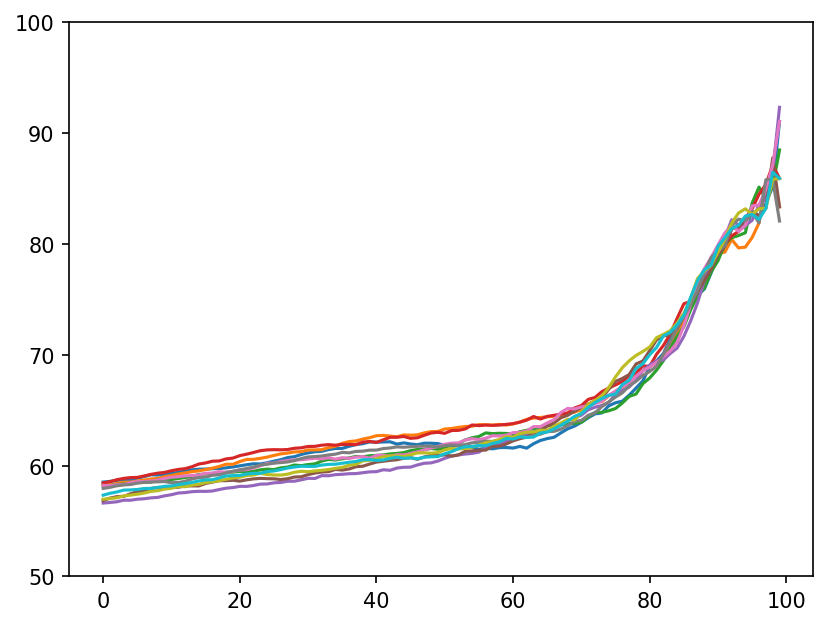

7
Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving
0
241/241 [==============================] - 34s 140ms/step
1
241/241 [==============================] - 34s 140ms/step
2
241/241 [==============================] - 34s 142ms/step
3
241/241 [==============================] - 34s 140ms/step
4
241/241 [==============================] - 34s 140ms/step
5
241/241 [==============================] - 35s 143ms/step
6
241/241 [==============================] - 34s 140ms/step
7
241/241 [==============================] - 34s 140ms/step
8
241/241 [==============================] - 35s 145ms/step
9
241/241 [==============================] - 34s 140ms/step


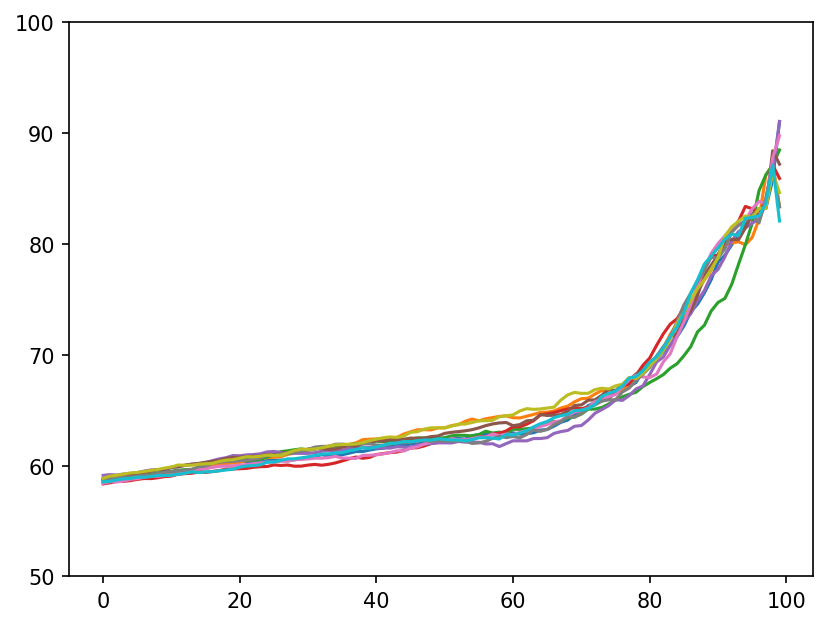

8
Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving
0
240/240 [==============================] - 33s 138ms/step
1
240/240 [==============================] - 33s 138ms/step
2
240/240 [==============================] - 33s 136ms/step
3
240/240 [==============================] - 32s 135ms/step
4
240/240 [==============================] - 32s 135ms/step
5
240/240 [==============================] - 33s 136ms/step
6
240/240 [==============================] - 32s 135ms/step
7
240/240 [==============================] - 33s 136ms/step
8
240/240 [==============================] - 32s 135ms/step
9
240/240 [==============================] - 32s 135ms/step


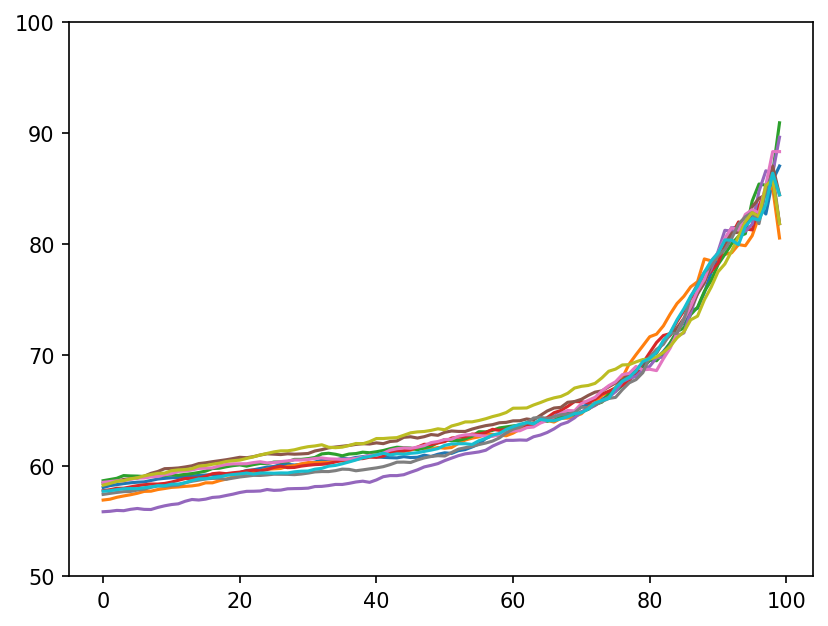

CPU times: user 20min 19s, sys: 44 s, total: 21min 3s
Wall time: 28min 13s


In [4]:
%%time
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain_increase'
hps = get_hp(EXP_NAME)
hps2 = get_hp(EXP_NAME2)

for i_trainmems in np.arange(5,9):
    print(i_trainmems)
    print('Training Members: '+str(hps2['train_mems'][i_trainmems]))
    print('Validation Member: '+str(hps2['val_mems'][0]))
    print('Testing Member: '+str(hps2['test_mems'][0]))
    print('Lead: '+str(hps2['LEAD']))
    print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

    _, _, X1test, _, _, Y1test,_ = split_retrain(trainmems = hps2['train_mems'][i_trainmems],
                                                  valmem = hps2['val_mems'][0],
                                                  testmem = hps2['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps2['LEAD'])
    
    #----- SET UP & TRAIN NN -----
    GLOBAL_SEED = hps['GLOBAL_SEED']
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.random.set_seed(GLOBAL_SEED)

    acc_all = []
    for SEED in range(10):
        print(SEED)
        cnn2fi_name = 'cnn2_'+EXP_NAME+'.'+str(i_trainmems)+'_seed'+str(SEED)+'.h5'
        cnn = tf.keras.models.load_model(base_dir+'CNNcheck/saved_models/'+cnn2fi_name)

        pred = cnn.predict(X1test)
        acc = []
        predconf = np.max(pred,axis=-1)
        predval  = np.argmax(pred,axis=-1)

        for q in range(100):
            iconf = np.where(predconf >= np.percentile(predconf,q=q))
            icorr = np.where(predval[iconf] == Y1test[iconf])

            acc.append((len(icorr[0])/len(iconf[0]))*100)
        plt.plot(acc)
        plt.ylim(50,100)

        acc_all.append(acc)
    plt.show()
    np.save(base_dir+'CNNcheck/confvsacc/confvsacc_cnn2_'+EXP_NAME2+'.'+str(i_trainmems)+'_cnn1_60Eshift_'+EXP_NAME+'.npy', acc_all, allow_pickle=True)
    del cnn, pred, predconf, predval, acc_all, acc, X1test, Y1test